# Exercises solutions

To set up an ABM simulation in Agents.jl, a user only needs to follow these steps:

1. **Choose** the kind of **space** that the agents will live in.

2. **Define** the **agent type** (or types, for mixed models) of the ABM.

3. **Define** the **model** within an Agents.jl simulation by using its universal structure `AgentBasedModel`.

4. Provide the **time evolution functions** of the ABM.

5. **Collect data**.

6. **Visualise** the model's time evolution.

## 1. Wright-Fisher model

### Neutral model

1. **Choose** the kind of **space** that the agents will live in.

There is no spatial structure, so we do not need to define it

2. **Define** the **agent type** (or types, for mixed models) of the ABM.

The agents are haploid individuals that have a `trait` property, which will represent the fitness of the agent on a range from 0 to 1. Given that there is no spatial structure, the agents will be `NoSpaceAgent`.

In [1]:
using Agents, Random

In [2]:
@agent Haploid NoSpaceAgent begin
    trait::Float64
end

3. **Define** the **model** within an Agents.jl simulation by using its universal structure `AgentBasedModel`.

We define the model with a seeded random number generator to make our simulation reproducible.

The agents will be activated randomly.

In [3]:
seed = 23182
rng = MersenneTwister(seed)

model = AgentBasedModel(Haploid; rng, scheduler = Schedulers.randomly)

StandardABM with 0 agents of type Haploid
 space: nothing (no spatial structure)
 scheduler: randomly

We have created the model but it is not populated with agents. Therefore, we will create an `initialize_model` function to populate the model.

We would like for our model to have the property `population_size` to freely modify the amount of individuals in the population.

To add agents to the model we will use `add_agent!([, pos], model, args...)`. It creates and adds a new agent to the model using the constructor of the agent type of the model. This function takes care of setting the agent's `id` and `position`. The extra `args` are propagated to other fields of the agent constructor. If the position of the agent is not given, the agent is added to a random position.

In [4]:
function initialize_model(;
    population_size = 100,
    #prng
    seed = 23182,
    )
    
    rng = MersenneTwister(seed)
    
    #model
    model = AgentBasedModel(Haploid; rng, scheduler = Schedulers.randomly)
    
    #Add agents to the model with a random value for the trait
    for _ in 1:population_size
        add_agent!(model, rand(model.rng))
    end
    
    return model
end

neutralmodel = initialize_model()

StandardABM with 100 agents of type Haploid
 space: nothing (no spatial structure)
 scheduler: randomly

4. Provide the **time evolution functions** of the ABM.

To create a new generation, we can use the `sample!` function. It choose random individuals with replacement from the current individuals and updates the model.

`sample!(model::ABM, n [, weight]; kwargs...)`

It replaces the agents of the model with a random sample of the current agents with size `n`.
* `weight`: Symbol (agent field) or function to weight the sampling. This means that the higher the weight of the agent, the higher the probability that this agent will be chosen in the new sampling.

We will also use the function `nagents(model)` to obtain the number of agents in the model.

*Note:*
To run the model for many generations and to collect the average trait value of the population, we will use a model-step function that utilizes `sample!`. There will not be an specifically defined agent-step function, therefore we will use `dummystep`.

In [5]:
modelstep_neutral!(model::ABM) = sample!(model, nagents(model))

modelstep_neutral! (generic function with 1 method)

We would like to collect the average trait value of the population and then visualise how it evolves over 1000 steps. 

5. **Collect data**.

To calculate the mean we will use the package `Statistics`.


To collect data, we should specify the data we want to collect by providing one standard Julia `Vector`of data-to-collect for agents. Running the model and collecting data while the model runs is done with the `run!` function. The agent data names are given as the keyword `adata` and the model as keyword `mdata` to the function `run!`. This function outputs collected data in the form of a `DataFrame`.

`run!(model, agent_step!, model_step!, n::Function; kwargs...) → agent_df, model_df`
* `adata::Vector{<:Tuple}`: if `adata` is a vector of tuples, data aggregation is done over the agent properties. For each 2-tuple, the first entry is the "key" (any entry like the ones mentioned above, e.g. `:weight, `). The second entry is an aggregating function that aggregates the key, e.g. `mean`,`maximum`. So, continuing from the above example, we would have `adata = [(:weight, mean), (f, maximum)]`

In [6]:
using Statistics

In [7]:
neutralmodel = initialize_model()
steps = 1000
adata = [(:trait, mean)]
adf, _ = run!(neutralmodel, dummystep, modelstep_neutral!, steps; adata)

(1001×2 DataFrame
  Row │ step   mean_trait 
      │ Int64  Float64    
──────┼───────────────────
    1 │     0    0.448785
    2 │     1    0.408471
    3 │     2    0.435391
    4 │     3    0.47503
    5 │     4    0.481061
    6 │     5    0.493968
    7 │     6    0.508151
    8 │     7    0.504515
    9 │     8    0.501417
   10 │     9    0.546989
   11 │    10    0.579801
  ⋮   │   ⋮        ⋮
  992 │   991    0.50456
  993 │   992    0.50456
  994 │   993    0.50456
  995 │   994    0.50456
  996 │   995    0.50456
  997 │   996    0.50456
  998 │   997    0.50456
  999 │   998    0.50456
 1000 │   999    0.50456
 1001 │  1000    0.50456
          980 rows omitted, 0×0 DataFrame)

6. **Visualise** the model's time evolution.

We will use the package `CairoMakie` to plot the evolution of the average trait.

In [8]:
using CairoMakie

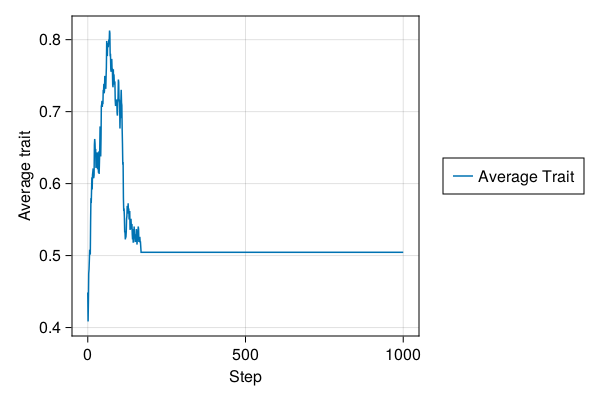

In [9]:
function plot_population_trait_average(adf)
    figure = Figure(resolution = (600, 400))
    ax = figure[1, 1] = Axis(figure; xlabel = "Step", ylabel = "Average trait")
    avg_trait = lines!(ax, adf.step, adf.mean_trait)
    figure[1, 2] = Legend(figure, [avg_trait], ["Average Trait"])
    figure
end

plot_population_trait_average(adf)

We can observe that the average trait converges to 0.5 for the neutral model. We will now add selection to the model.

## Model with selection

To add selection we just need to sample individuals according to their trait values. We assume that their fitness is correlated with their trait values.

Therefore, we just need to create a new model-step function.

In [10]:
modelstep_selection!(model::ABM) = sample!(model, nagents(model), :trait)

modelstep_selection! (generic function with 1 method)

In [11]:
model_with_selection = initialize_model()
steps = 1000
adata = [(:trait, mean)]
adf, _ = run!(model_with_selection, dummystep, modelstep_selection!, steps; adata)

(1001×2 DataFrame
  Row │ step   mean_trait 
      │ Int64  Float64    
──────┼───────────────────
    1 │     0    0.448785
    2 │     1    0.581041
    3 │     2    0.670889
    4 │     3    0.7511
    5 │     4    0.818912
    6 │     5    0.827981
    7 │     6    0.874611
    8 │     7    0.902536
    9 │     8    0.929099
   10 │     9    0.932302
   11 │    10    0.932494
  ⋮   │   ⋮        ⋮
  992 │   991    0.985459
  993 │   992    0.985459
  994 │   993    0.985459
  995 │   994    0.985459
  996 │   995    0.985459
  997 │   996    0.985459
  998 │   997    0.985459
  999 │   998    0.985459
 1000 │   999    0.985459
 1001 │  1000    0.985459
          980 rows omitted, 0×0 DataFrame)

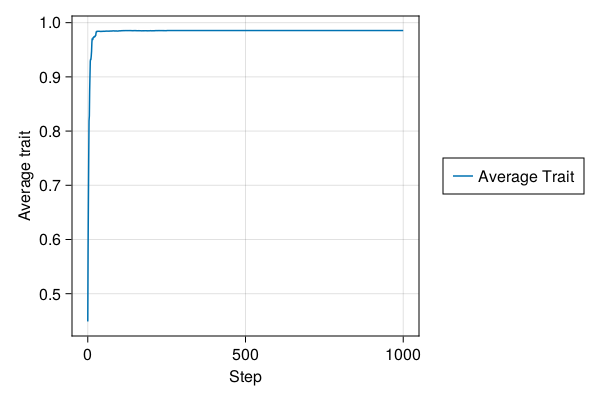

In [12]:
plot_population_trait_average(adf)

For the model with selection, the trait average converges to 1. This is expected because agents with higher traits have a higher probability of being sample for the next generation.

## Spatial Rock-Paper-Scissors

The code implements the model described in [Reichenbach, T., Mobilia, M. & Frey, E. (2007). Mobility promotes and jeopardizes biodiversity in rock-paper-scissors game.](https://www.nature.com/articles/nature06095)

1. **Choose** the kind of **space** that the agents will live in.

The 3 subpopulations are arranged in a two-dimensional square lattice with periodic boundary conditions. An agent can only interact with its 4 nearest neighbours, therefore we use `metric = :manhattan`.

In [13]:
using Agents, Random

In [14]:
dims = (50, 50)
space = GridSpace(dims, periodic = true, metric = :manhattan)

GridSpace with size (50, 50), metric=manhattan, periodic=true

2. **Define** the **agent type** (or types, for mixed models) of the ABM.


In [15]:
@agent Strategy GridAgent{2} begin
    #:rock, :paper or :scissors
    type::Symbol
end
    
Rock(id, pos) = Strategy(id, pos, :rock)
Paper(id, pos) = Strategy(id, pos, :paper)
Scissors(id, pos) = Strategy(id, pos, :scissors)

Scissors (generic function with 1 method)

3. **Define** the **model** within an Agents.jl simulation by using its universal structure `AgentBasedModel`.

The selection, reproduction and exchange rate are model properties.

We define the model with a seeded random number generator to make our simulation reproducible.

The agents will be activated randomly.

In [16]:
#model properties
properties = (
    selection_rate = selection_rate,
    reproduction_rate = reproduction_rate,
    exchange_rate = exchange_rate,
)

seed = 23182
rng = MersenneTwister(seed)

model = AgentBasedModel(Strategy, space; rng, scheduler = Schedulers.randomly)

LoadError: UndefVarError: selection_rate not defined

We have created the model but it is not populated with agents. Therefore, we will create an `initialize_model` function to populate the model.

The parameters of our model will be the number of agents of each type and the reaction rates.

To add agents to the model we will use `add_agent!([, pos], model, args...)`. It creates and adds a new agent to the model using the constructor of the agent type of the model. This function takes care of setting the agent's `id` and `position`. The extra `args` are propagated to other fields of the agent constructor. If the position of the agent is not given, the agent is added to a random position.

`nextid(model)`: returns a valid `id` for creating a new agent with it.

`random_position(model)`: returns a random position in the model's space.

In [17]:
function initialize_model(;
    #agents
    n_rock = 800,
    n_paper = 800,
    n_scissors = 800,
    #space
    dims = (50, 50),
    #reaction rates
    selection_rate = 1.0,
    reproduction_rate = 1.0,
    exchange_rate = 0.7, 
    #prng
    seed = 23182,
    )
    
    rng = MersenneTwister(seed)
    
    #space
    space = GridSpace(dims, periodic = true, metric = :manhattan)
    
    #model properties
    properties = (
        selection_rate = selection_rate,
        reproduction_rate = reproduction_rate,
        exchange_rate = exchange_rate,
    )
    
    #model
    model = AgentBasedModel(Strategy, space; properties, rng, scheduler = Schedulers.randomly)
    
    #Add agents to the model to a random position
    for _ in 1:n_rock
        add_agent_pos!(Rock(nextid(model), random_position(model)), model)
    end
    
    for _ in 1:n_paper
        add_agent_pos!(Paper(nextid(model), random_position(model)), model)
    end
    
    for _ in 1:n_scissors
        add_agent_pos!(Scissors(nextid(model), random_position(model)), model)
    end
    
    return model
end

rockpaperscissors = initialize_model()

StandardABM with 2400 agents of type Strategy
 space: GridSpace with size (50, 50), metric=manhattan, periodic=true
 scheduler: randomly
 properties: selection_rate, reproduction_rate, exchange_rate

4. Provide the **time evolution functions** of the ABM.

Agents interact with their nearest 4 neighbours through selection or reproduction, both of which reactions occur as Poisson processes at rates $\sigma$ and $\mu$.
In addition, the model explores the effect of mobility on the diversity of the population via the exchange rate $\epsilon$.

* Selection reflects cyclic dominance: Rock --> Scissors --> Paper --> Rock
* Reproduction of individuals is only allowed on empty neighbouring sites, to mimic a finite carrying capacity of the system.
* Mobility is represented via $\epsilon$, this exchange rate represent the likelihood of agents to swap position with a neighbouring individual or hop onto an empty neighbouring site.

Overall, the agent step is defined via the Gillespie algorithm.

In [18]:
function strategy_step!(strategy, model)
    #propensities
    a1 = model.selection_rate * nagents(model)
    a2 = model.reproduction_rate * nagents(model)
    a3 = model.exchange_rate * nagents(model)
    
    #total propensities
    a0 = a1 + a2 + a3
    
    p = rand(model.rng)
    if 0 <= p <= a1/a0
        selection_RPS!(strategy, model)
    elseif a1/a0<= p <(a1+a2)/a0
        reproduce!(strategy, model)
    elseif (a1+a2)/a0 <= p < 1
        swap!(strategy, model)
    end
end

strategy_step! (generic function with 1 method)

In [19]:
function selection_RPS!(strategy, model)
    contender = random_nearby_agent(strategy, model) 
    if !isnothing(contender)
        pos_contender = contender.pos
        if strategy.type == :rock && contender.type == :scissors
            kill_agent!(contender, model)
        elseif strategy.type == :scissors && contender.type == :paper
            kill_agent!(contender, model)
        elseif strategy.type == :paper && contender.type == :rock
            kill_agent!(contender, model)
        end
    end 
    return
end

selection_RPS! (generic function with 1 method)

In [20]:
function reproduce!(strategy, model)
    pos_offspring = positions_empty_neighbours(strategy.pos, model)
    if !isnothing(pos_offspring)
        id = nextid(model)
        offspring =  Strategy(id, pos_offspring[1], strategy.type)
        add_agent_pos!(offspring, model)
    end
    return
end

reproduce! (generic function with 1 method)

In [21]:
function positions_empty_neighbours(pos, model)
    array_empty_neighbours = Tuple{Int64, Int64}[]
    for i in nearby_positions(pos, model)
        if isempty(i, model)
            push!(array_empty_neighbours, i)  
        end
    end
    
    if isempty(array_empty_neighbours)
        return nothing
    else
        return array_empty_neighbours
    end  
end

positions_empty_neighbours (generic function with 1 method)

In [22]:
function swap!(strategy, model)
    rand_pos = random_nearby_position(strategy.pos, model)
    
    if isempty(rand_pos, model)
        move_agent!(strategy, rand_pos, model)
    else
        strategy_pos = strategy.pos
        id = ids_in_position(rand_pos, model)[1]
        other_agent = model[id]
        move_agent!(strategy, rand_pos, model)
        move_agent!(other_agent, strategy_pos, model)   
    end
    return
end

swap! (generic function with 1 method)

In [23]:
function random_nearby_position(pos, model)
    array_nearby_positions = collect(nearby_positions(pos, model))
    
    num_neighbours = length(array_nearby_positions)
    rand_num = rand(model.rng, 1:num_neighbours)
    
    return array_nearby_positions[rand_num]
end

random_nearby_position (generic function with 1 method)

6. **Visualise** the model's time evolution.

We will animate the evolution of the model via `abmvideo`.

In [24]:
using InteractiveDynamics, CairoMakie

In [25]:
function strategycolor(a)
    if a.type == :rock
        :blue
    elseif a.type == :paper
        :yellow
    else
        :red
    end
end

plotkwargs = (;
    ac = strategycolor,
    am = :rect,
)

(ac = strategycolor, am = :rect)

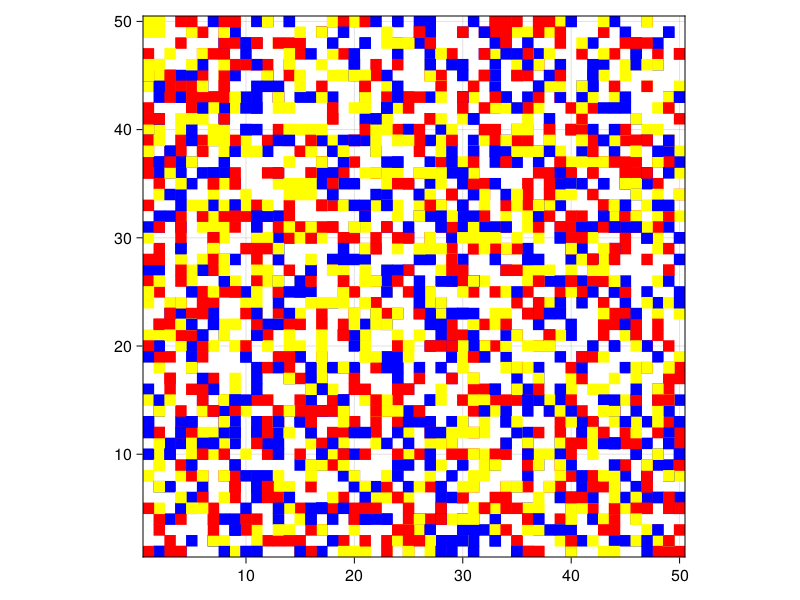

In [26]:
fig, _ = abmplot(rockpaperscissors;
plotkwargs...)

display(fig)

In [27]:
abmvideo(
    "Rock_Paper_Scissors.mp4",
    rockpaperscissors,
    strategy_step!;
    frames = 500,
    framerate = 8,
    title = "Spatial Rock-Paper-Scissors game",
    plotkwargs...,
)